In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import joblib
import os, sys, random, asyncio, argparse

# Load your dataset
new_file_path = 'heart_records_100k.csv'
heart_records_data = pd.read_csv(new_file_path)

# Display the first few rows of the new dataset to understand its structure
print(heart_records_data.head())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


In [2]:
# Step 1: Data Preprocessing (Encoding and Scaling)

# Copy the data for manipulation
df = heart_records_data.copy()

# Encode categorical variables into numeric values
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])
df['ChestPainType'] = label_encoder.fit_transform(df['ChestPainType'])
df['RestingECG'] = label_encoder.fit_transform(df['RestingECG'])
df['ExerciseAngina'] = label_encoder.fit_transform(df['ExerciseAngina'])
df['ST_Slope'] = label_encoder.fit_transform(df['ST_Slope'])

# Define features (X) and target (y)
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for future use
joblib.dump(scaler, 'new_scaler.pkl')

['new_scaler.pkl']

In [3]:
import sys
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Step 2: Hyperparameter Tuning with RandomizedSearchCV

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize Random Forest with class weight balancing
rfc_with_class_weight = RandomForestClassifier(random_state=42, class_weight='balanced')

# RandomizedSearchCV for hyperparameter tuning
random_search_balanced = RandomizedSearchCV(
    rfc_with_class_weight, param_distributions=param_dist, n_iter=20, cv=5, verbose=2, n_jobs=-1, random_state=42
)

# Perform RandomizedSearchCV with cross-validation on the training set
random_search_balanced.fit(X_train_scaled, y_train)

# Get the best hyperparameters and the best estimator
best_model_balanced = random_search_balanced.best_estimator_
best_params_balanced = random_search_balanced.best_params_
print("DONE!",flush=True)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
DONE!


In [9]:
# Step 3: Retrain the Best Model on the Entire Training Set

# Train the final model using the best hyperparameters
best_model_balanced.fit(X_train_scaled, y_train)

# Progress bar for model training
with tqdm(total=100, desc="Training Progress") as pbar:
    for _ in range(10):  # Simulate 10 updates
        rfc_with_class_weight.fit(X_train_scaled, y_train)
        pbar.update(20)
        
# Save the model to a file
model_file = 'best_random_forest_model.pkl'
joblib.dump(best_model_balanced, model_file)

print(f"Model saved as {model_file}")

# Step 4: Evaluate the Model on the Test Set

# Predictions on the test set
y_pred = best_model_balanced.predict(X_test_scaled)

print("DONE!")

Training Progress: 200it [01:31,  2.18it/s]                                                                            


Model saved as best_random_forest_model.pkl
DONE!


In [10]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 92.09%


In [11]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     10404
           1       0.95      0.91      0.93     12776

    accuracy                           0.92     23180
   macro avg       0.92      0.92      0.92     23180
weighted avg       0.92      0.92      0.92     23180



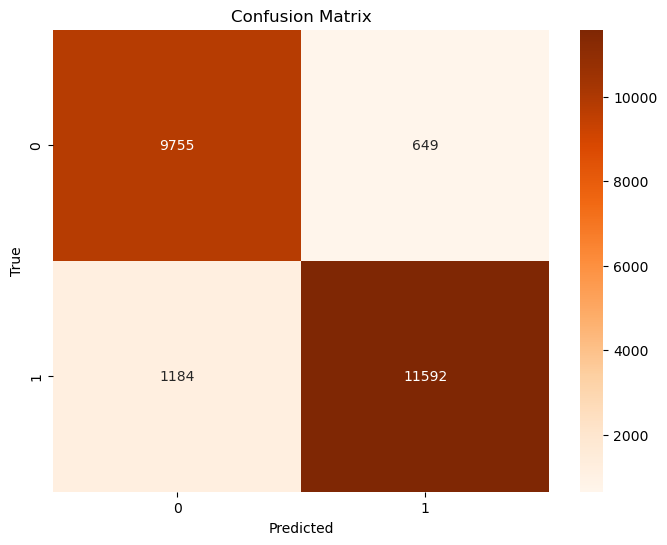

In [12]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Oranges")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

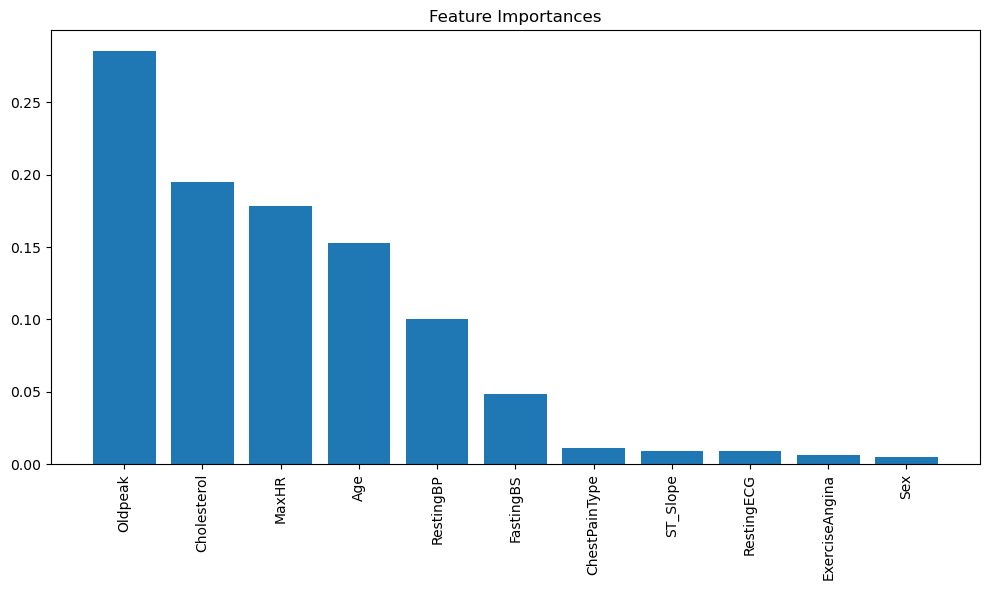

In [13]:
# Feature Importance
importances = best_model_balanced.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()